### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import shuffle
%matplotlib inline

### Functions

In [22]:
class Model(nn.Module):
    def __init__(self, n_users, n_items, embed_dim, n_hidden=1024,mode="Optimized"):
        super(Model, self).__init__()
        self.N = n_users
        self.M = n_items
        self.D = embed_dim
        self.mode = mode

        self.u_emb = nn.Embedding(self.N, self.D)
        self.m_emb = nn.Embedding(self.M, self.D)
        self.fc1 = nn.Linear(2*self.D, n_hidden)
        self.fc2 = nn.Linear(n_hidden, 1)

        if self.mode=="Optimized":
            self.u_emb.weight.data = nn.Parameter(
                torch.Tensor(np.random.randn(self.N, self.D)* 0.01))
            
            self.m_emb.weight.data = nn.Parameter(
                torch.Tensor(np.random.randn(self.M, self.D)* 0.01))


    
    def forward(self, u, m):
        u = self.u_emb(u)
        m = self.m_emb(m)

        out = torch.cat((u,m),1)

        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out



def from_numpy_shuffle_all_in_one(user_ids, movie_ids, ratings):
    user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)

    user_ids_t  = torch.from_numpy(user_ids).long()
    movie_ids_t = torch.from_numpy(movie_ids).long()
    ratings_t   = torch.from_numpy(ratings).long()

    return user_ids_t, movie_ids_t, ratings_t

def make_dataset(user_ids_t, movie_ids_t, ratings_t, percentage,mode="Optimized"):

    Ntrain = int(percentage * len(ratings))

    if mode=="Simple":
        train_dataset = torch.utils.data.TensorDataset(
            user_ids_t[:Ntrain],
            movie_ids_t[:Ntrain],
            ratings_t[:Ntrain],
        )
        test_dataset = torch.utils.data.TensorDataset(
            user_ids_t[Ntrain:],
            movie_ids_t[Ntrain:],
            ratings_t[Ntrain:],
        )

    elif mode=="Optimized":

        train_dataset = (
            user_ids_t[:Ntrain],
            movie_ids_t[:Ntrain],
            ratings_t[:Ntrain],
        )
        test_dataset = (
            user_ids_t[Ntrain:],
            movie_ids_t[Ntrain:],
            ratings_t[Ntrain:],
        )
    return train_dataset, test_dataset


def data_loader_maker(train_dataset, test_dataset, batch_size):
    train_loader =  torch.utils.data.DataLoader(dataset=train_dataset,
                                                batch_size = batch_size,
                                                shuffle = True
                                                )
    test_loader =  torch.utils.data.DataLoader(dataset=test_dataset,
                                                batch_size = batch_size,
                                                shuffle = True
                                                )
    
    return train_loader, test_loader


def create_model_and_train(user_ids,movie_ids,ratings,N,M,D,n_epochs=100,batch_size=512,percentage=0.8,mode="Optimized",optimizer_mode="SGD"):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    model = Model(n_users=N, n_items=M, embed_dim=D, n_hidden=1024,mode=mode)

    model.to(device)
    
    criterion = nn.MSELoss()
    if optimizer_mode=="Adam":
        optimizer = torch.optim.Adam(model.parameters())
    elif optimizer_mode=="SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.9)


    train_losses = np.zeros(n_epochs)
    test_losses  = np.zeros(n_epochs)
    
    if mode=="Optimized":
        train_dataset, test_dataset = make_dataset(user_ids, movie_ids, ratings, percentage,mode=mode)
        train_users, train_movies, train_ratings = train_dataset
        test_users, test_movies, test_ratings = test_dataset
        Ntrain = len(train_users)
        Ntest = len(test_users)

        batches_per_epoch = int(np.ceil(Ntrain/batch_size))
        batches_per_epoch_test = int(np.ceil(Ntest/batch_size))

        for it in range(n_epochs):
            t0 = datetime.now()
            train_loss = []

            train_users, train_movies, train_ratings = shuffle(train_users, train_movies, train_ratings)

            for j in range(batches_per_epoch):
                users   = train_users[j*batch_size:(j+1)*batch_size]
                movies  = train_movies[j*batch_size:(j+1)*batch_size]
                targets = train_ratings[j*batch_size:(j+1)*batch_size]

                users   = torch.from_numpy(users).long()
                movies  = torch.from_numpy(movies).long()
                targets = torch.from_numpy(targets)

                targets = targets.view(-1,1).float()
                users, movies, targets = users.to(device), movies.to(device), targets.to(device)

                optimizer.zero_grad()
            
                outputs = model(users, movies)
                loss = criterion(outputs, targets)
            
                loss.backward()
                optimizer.step()
                train_loss.append(loss.item())
            
            train_losses[it] = np.mean(train_loss)


            test_loss = []
            for j in range(batches_per_epoch_test):
                users   = test_users[j*batch_size:(j+1)*batch_size]
                movies  = test_movies[j*batch_size:(j+1)*batch_size]
                targets = test_ratings[j*batch_size:(j+1)*batch_size]

                users   = torch.from_numpy(users).long()
                movies  = torch.from_numpy(movies).long()
                targets = torch.from_numpy(targets)

                targets = targets.view(-1,1).float()
                users, movies, targets = users.to(device), movies.to(device), targets.to(device)

            
                outputs = model(users, movies)
                loss = criterion(outputs, targets)
                test_loss.append(loss.item())
            
            test_losses[it] = np.mean(test_loss)

            dt = datetime.now() - t0

            # if (it+1)%5==0:

            print(f"Epoch {it+1}/{n_epochs}, Train Loss: {train_losses[it]:.4f}, Test Loss: {test_losses[it]:.4f}, Duration Time: {dt}")
            

    elif mode=="Simple":

        user_ids_t, movie_ids_t, ratings_t = from_numpy_shuffle_all_in_one(user_ids, movie_ids, ratings)
        train_dataset, test_dataset = make_dataset(user_ids_t, movie_ids_t, ratings_t, percentage)
        train_loader, test_loader = data_loader_maker(train_dataset, test_dataset, batch_size)


        for it in range(n_epochs):
            t0 = datetime.now()
            train_loss = []
            for users, movies, targets in train_loader:
                targets = targets.view(-1,1).float()

                users, movies, targets = users.to(device), movies.to(device), targets.to(device)

                optimizer.zero_grad()
            
                outputs = model(users, movies)
                loss = criterion(outputs, targets)
            
                loss.backward()
                optimizer.step()
                train_loss.append(loss.item())
            
            train_losses[it] = np.mean(train_loss)


            test_loss = []
            for users, movies, targets in test_loader:
                targets = targets.view(-1,1).float()

                users, movies, targets = users.to(device), movies.to(device), targets.to(device)

            
                outputs = model(users, movies)
                loss = criterion(outputs, targets)
                test_loss.append(loss.item())
            
            test_losses[it] = np.mean(test_loss)

            dt = datetime.now() - t0

            # if (it+1)%5==0:

            print(f"Epoch {it+1}/{n_epochs}, Train Loss: {train_losses[it]:.4f}, Test Loss: {test_losses[it]:.4f}, Duration Time: {dt}")
            
    return model,train_losses, test_losses

def plot_metric(data, metric):
    plt.plot(data, label=metric)
    plt.legend()
    plt.show

### Download and Load data

In [3]:
!wget -nc https://files.grouplens.org/datasets/movielens/ml-20m.zip

--2021-09-29 08:34:36--  https://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  16.2MB/s    in 21s     

2021-09-29 08:34:57 (9.09 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



In [4]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [5]:
df = pd.read_csv("ml-20m/ratings.csv")

In [6]:
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [7]:
# set our own 0 to N-1 ids
df.userId = pd.Categorical(df.userId)
df["new_user_id"] = df.userId.cat.codes

In [8]:
df.movieId = pd.Categorical(df.movieId)
df["new_movie_id"] = df.movieId.cat.codes

In [9]:
user_ids = df["new_user_id"].values
movie_ids = df["new_movie_id"].values
ratings = df["rating"].values - 2.5

In [10]:
print(np.max(df["rating"].values))

5.0


In [11]:
N = len(set(user_ids))
M = len(set(movie_ids))

# embedding dimension
D = 10

In [24]:
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)

### Create and train model

In [25]:
# %prun model,train_losses, test_losses = create_model_and_train(user_ids,movie_ids,ratings,N,M,D,n_epochs=3,batch_size=512,percentage=0.8)

In [26]:
%prun model,train_losses, test_losses = create_model_and_train(user_ids,movie_ids,ratings,N,M,D,n_epochs=20,batch_size=512,percentage=0.8,mode="Optimized",optimizer_mode="SGD")

cuda:0
Epoch 1/20, Train Loss: 0.7363, Test Loss: 0.6976, Duration Time: 0:01:15.333425
Epoch 2/20, Train Loss: 0.6703, Test Loss: 0.6654, Duration Time: 0:01:15.293547
Epoch 3/20, Train Loss: 0.6371, Test Loss: 0.6521, Duration Time: 0:01:15.061256
Epoch 4/20, Train Loss: 0.6142, Test Loss: 0.6400, Duration Time: 0:01:14.598542
Epoch 5/20, Train Loss: 0.5976, Test Loss: 0.6342, Duration Time: 0:01:14.244366
Epoch 6/20, Train Loss: 0.5843, Test Loss: 0.6322, Duration Time: 0:01:14.235583
Epoch 7/20, Train Loss: 0.5744, Test Loss: 0.6317, Duration Time: 0:01:14.426406
Epoch 8/20, Train Loss: 0.5669, Test Loss: 0.6386, Duration Time: 0:01:14.361639
Epoch 9/20, Train Loss: 0.5612, Test Loss: 0.6323, Duration Time: 0:01:14.429467
Epoch 10/20, Train Loss: 0.5564, Test Loss: 0.6263, Duration Time: 0:01:14.704506
Epoch 11/20, Train Loss: 0.5524, Test Loss: 0.6255, Duration Time: 0:01:14.561513
Epoch 12/20, Train Loss: 0.5491, Test Loss: 0.6250, Duration Time: 0:01:14.756280
Epoch 13/20, Train

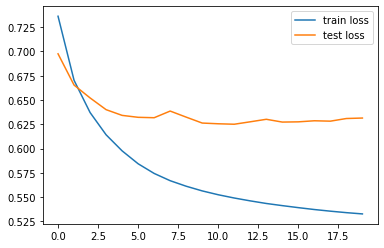

In [27]:
plot_metric(train_losses, "train loss")
plot_metric(test_losses, "test loss")